# Redes Neurais

## Sumário

1. [Introdução](#1.-Introdução)
    - [Stratégia 1: Busca Aleatória](#Stratégia-1:-Busca-Aleatória)
    - [Stratégia 2: Busca Aleatória Local](#Stratégia-2:-Busca-Aleatória-Local)
    - [Stratégia 3: Gradiente Numérico](#Stratégia-3:-Gradiente-Numérico)
    - [Stratégia 4: Gradiente Analítico](#Stratégia-4:-Gradiente-Analítico)
    - [Caso Recursivo: Múltiplas Portas](#Caso-Recursivo:-Múltiplas-Portas)
2. [Backpropagation](#2.-Backpropagation)
    - [Se tornando um Ninja em Backpropagation](#Se-tornando-um-Ninja-em-Backpropagation!)
    - [Resumo dos Padrões na Backpropagation](#Resumo-dos-Padrões-na-Backpropagation)
    - [Exemplo 1](#Exemplo-1)
    - [Exemplo 2](#Exemplo-2)
3. [Classificação Linear](#3.-Classificação-Linear)
    - [Score Function](#Score-Function)
    - [Loss Function](#Loss-Function)
    - [Regularização](#Regularização)
4. [Redes Neurais](#4.-Redes-Neurais)
    - [Funções de Ativação](#Funções-de-Ativação)
    - [Configuração dos Dados e do Modelo da Rede](#Configuração-dos-Dados-e-do-Modelo-da-Rede)
        - [Pré-Processamento dos Dados](#Pré-Processamento-dos-Dados)
        - [Inicialização dos Pesos](#Inicialização-dos-pesos)
        - [Número e tamanho das camadas](#Número-e-Tamanho-das-Camadas)
5. [Colocando em Prática](#Colocando em Prática)
    - [Exemplo 1: Classificador Linear](#Exemplo-1:-Classificador-Linear)
    - [Exemplo 2: Classificador Softmax](#Exemplo-2:-Classificador-Softmax)
    - [Exemplo 3: Rede Neural](#Exemplo-3:-Rede-Neural)
    - [Exemplo 4: Rede Neural Parametrizável](#Exemplo-4:-Rede-Neural-Parametrizável)

## 0. Importando as bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Introdução

A melhor maneira de pensar em redes neurais é como circuitos de valores reais. Mas, ao invés de valores booleanos, valores reais e, ao invés de portas lógicas como **and** ou **or**, portas binárias (dois operandos) como $*$ (multiplicação), + (adição), max, exp, etc. Além disso, também teremos **gradientes** fluindo pelo circuito, mas na direção oposta.

<img src='images/MultGate.png' width="250">

In [2]:
def forwardMultiplyGate(a, b):
    return a*b

forwardMultiplyGate(-2,3)

-6

De forma matemática, a gente pode considerar que essa porta implementa a seguinte função:

$$f(x,y)=x*y$$

### O Objetivo

Vamos imaginar que temos o seguinte problema:
1. Nós vamos providenciar a um circuito valores específicos como entrada (x=-2, y=3)
2. O circuito vai calcular o valor de saída (-6)
3. A questão é: *Quanto mudar a entrada para levemente **aumentar** a saída?*

No nosso caso, em que direção devemos mudar x,y para conseguir um número maior que -6? Note que, pro nosso exemplo, se x = -1.99 e y = 2.99, x$*$y = -5.95 que é maior que -6. **-5.95 é melhor (maior) que 6**, e obtivemos uma melhora de 0.05.

### Stratégia 1: Busca Aleatória

Ok. Isso não é trivial? A gente pode simplesmente gerar valores aleatórios, calcular a saída e guardar o melhor resultado.

In [3]:
x,y = -2,3
melhor_saida = forwardMultiplyGate(x,y)
melhor_x, melhor_y = 0,0

for k in range(0,100):
    x_try = 5*np.random.random() - 5
    y_try = 5*np.random.random() - 5
    out = forwardMultiplyGate(x_try, y_try)
    
    if out > melhor_saida:
        melhor_saida = out
        melhor_x, melhor_y = x_try, y_try

print(melhor_x, melhor_y, forwardMultiplyGate(melhor_x, melhor_y))

-4.271184927854167 -4.822647397160366 20.598418875106482


Ok, foi bem melhor. Mas, e se tivermos milhões de entradas? É claro que essa estratégia não funcionará. Vamos tentar algo mais aprimorado.

### Stratégia 2: Busca Aleatória Local

In [4]:
x,y = -2,3
passo = 0.01
melhor_saida = forwardMultiplyGate(x,y)
melhor_x, melhor_y = 0,0

for k in range(0,100):
    x_try = x + passo * (2*np.random.random() - 1)
    y_try = y + passo * (2*np.random.random() - 1)  
    out = forwardMultiplyGate(x_try, y_try)
    
    if out > melhor_saida:
        melhor_saida = out
        melhor_x, melhor_y = x_try, y_try

print(melhor_x, melhor_y, forwardMultiplyGate(melhor_x, melhor_y))

-1.9900846119235958 2.9900425728675333 -5.950437713260115


### Stratégia 3: Gradiente Numérico

Imagine agora que a gente pega as entradas de um circuito e puxa-as para uma direção positiva. Essa força puxando x e y vai nos dizer como x e y devem mudar para aumentar a saída. Não entendeu? Vamos explicar:

Se olharmos para as entradas, a gente pode intuitivamente ver que a força em x deveria sempre ser positiva, porque tornando x um pouquinho maior de **x=-2** para **x=-1** aumenta a saída do circuito para **-3**, o que é bem maior que -6. Por outro lado, se a força em y for negativa, tornando-o menor, como de **y=3** para **y=2**, também aumenta a saída: -2x2 = -4, de novo maior que -6.

E como calcular essa força? Usando **derivadas**.

> *A derivada pode ser pensada como a força que a gente aplica em cada entrada para aumentar a saída*

E como exatamente a gente vai fazer isso? Em vez de olhar para o valor de saída, como fizemos anteriormente, nós vamos iterar sobre as cada entrada individualmente, aumentando-as bem devagar e vendo o que acontece com a saída. **A quantidade que a saída muda é a resposta da derivada**.

Vamos para definição matemática. A derivada em relação a x da nossa porta pode ser definida como:

$$\frac{\partial f(x,y)}{\partial x} = \frac{f(x+h,y) - f(x,y)}{h}$$

Onde ***h*** é pequeno. Nós vamos, então, calcular a saída inicial $f(x,y)$ e aumentar x por um valor pequeno ***h*** e calcular a nova saída $f(x+h,y)$. Então, nós subtraimos esse valores para ver a diferença e dividimos por $f(x+h,y)$ para normalizar essa mudança pelo valor (arbitrário) que nós usamos.

Em termos de código, teremos:

In [5]:
x,y = -2,3
out = forwardMultiplyGate(x,y)
h = 0.0001

# derivada em relação a x
xph = x + h
out2 = forwardMultiplyGate(xph, y)
derivada_x = (out2 - out)/h

# derivada em relação a y
yph = y + h
out3 = forwardMultiplyGate(x, yph)
derivada_y = (out3 - out)/h

print(out2, out3)
print(derivada_x, derivada_y)

-5.9997 -6.0002
3.00000000000189 -2.0000000000042206


Como a gente pode ver, a derivada em relação a x é igual a **+3**. O sinal positivo indica que o alterando o valor de x pelo passo h, a saída se torna maior. O valor 3 pode ser considerado como o valor da força que puxa x. O inverso acontece com y.

> *A derivada em relação a alguma entrada pode ser calculada ajustando levemente aquela entrada e observando a mudança no valor da saída*

A derivada é calculada sobre cada entrada, enquanto o **gradiente** representa todas as derivadas sobre as entradas concatenadas em um vetor.

In [6]:
passo = 0.01
out = forwardMultiplyGate(x,y)
x = x + passo * derivada_x
y = y + passo * derivada_y
out_new = forwardMultiplyGate(x,y)

print(out_new)

-5.87059999999986


Como a gente pode perceber -5.87 > -6. Apenas 3 avaliações foram necessárias para aumentar o valor da saída (ao invés de centenas) e conseguimos um melhor resultado.

**Passo maior nem sempre é melhor**: É importante destacar qualque valor de passo maior que 0.01 ia sempre funcionar melhor (por exemplo, passo = 1 gera a saída = 1). No entanto, a medida que os circuitos vão ficando mais complexos (como em redes neurais completas), a função vai ser tornando mais caótica e complexa. O gradiente garante que se você tem um passo muito pequeno (o ideal seria infinitesimal), então vou definitivamente aumenta a saída seguindo aquela direção. O passo que estamos utilizando (0.01) ainda é muito grande, mas como nosso circuito é simples, podemos esperar pelo melhor resultado. Lembre-se da analogia do **escalador cego**.

### Stratégia 4: Gradiente Analítico

A estratégia que utilizamos até agora de ajustar levemente a entrada e ver o que acontece pode não ser muito cômoda na prática quando temos milhares de entradas para ajustar. Então, a gente precisa de algo melhor.

Felizmente, existe uma estratégia mais fácil e muito mais rápida para calcular o gradiente: podemos usar cálculo para derivar diretamente a nossa função. Chamamos isso de **gradiente analítico** e dessa forma não precisamos ajustar levemente nada. 

> *O gradiente analítico evita o leve ajustamento das entradas. O circuito pode ser derivado usando cálculo.*

É muito fácil calcular derivadas parciais para funções simples como x$*$y. Se você não lembra da definição, aqui está o cálculo da derivada parcial em relação a x da nossa função $f(x,y)$:

$$\frac{\partial f(x,y)}{\partial x} = \frac{f(x+h,y) - f(x,y)}{h}
= \frac{(x+h)y - xy}{h}
= \frac{xy + hy - xy}{h}
= \frac{hy}{h}
= y$$

A derivada parcial em relação em x da nossa $f(x,y)$ é igual y. Você reparou na coincidência de *derivada_x = 3.0*, que é exatamente o valor de y? E que o mesmo aconteceu para x? **Então, a gente não precisa ajustar nada!** E nosso código fica assim:

In [7]:
x,y = -2,3
out = forwardMultiplyGate(x,y)
gradient_x = y
gradient_y = x

x = x + passo*gradient_x
y = y + passo*gradient_y
out_new = forwardMultiplyGate(x,y)

print(out_new)

-5.8706


É importante destacar que a Estratégia #3 reduziu a #2 para uma única vez. Porém, a #3 nos dá somente uma aproximação do gradiente, enquanto a Estratégia #4 nos dá o valor *exato*. Sem aproximações. O único lado negativo é que temos de saber derivar a nossa funcão.

Recapitulando o que vimos até aqui:
- Estratégia 1: definimos valores aleatórios em todas as iterações. Não funciona para muitas entradas.
- Estratégia 2: pequenos ajustes aleatórios as entradas e vemos qual funciona melhor. Tão ruim quando a #1.
- Estratégia 3: muito melhor através do cálculo do gradiente. Independentemente de quão complicado é o circuito, o **gradiente numérico** é muito simples de se calcular (mas um pouco caro).
- Estratégia 4: no final, vimos que a forma melhor, mais inteligente e mais rápida é calcular o **gradiente analítico**. O resultado é idêntico ao gradiente numérico, porém mais rápido e não precisa de ajustes.

### Caso Recursivo: Múltiplas Portas

Calcular o gradiente para o nosso circuito foi trivial. Mas, e em circuitos mais complexos? Como a gente vai ver agora, cada porta pode ser tratada individualmente e a gente pode computar derivadas locais como a gente fez anteriormente. Vamos considerar nossa função agora como segue:

$$f(x,y,z) = (x+y)*z$$

<img src='images/Gate2.png' width='300'>



In [8]:
def forwardAddGate(a, b):
    return a+b

def forwardCircuit(x,y,z):
    q = forwardAddGate(x,y)
    f = forwardMultiplyGate(q, z)
    return f

print(forwardCircuit(-2, 5, -4))

-12


Como vamos calcular agora a nossa derivada? Primeiramente, vamos esquecer da porta de soma e fingir que temos apenas duas entradas no nosso circuito: **q** e **z**. Como já vimos, as nossas derivadas parciais podem ser definidas como segue:

$$f(q,z) = q z \hspace{0.5in} \implies \hspace{0.5in} \frac{\partial f(q,z)}{\partial q} = z, \hspace{1in} \frac{\partial f(q,z)}{\partial z} = q$$

Ok, mas e em relação a x e y? Como q é calculado em função de x e y (pela adição em nosso exemplo), nós também podemos calcular suas derivadas parciais:

$$q(x,y) = x + y \hspace{0.5in} \implies \hspace{0.5in} \frac{\partial q(x,y)}{\partial x} = 1, \hspace{1in} \frac{\partial q(x,y)}{\partial y} = 1$$

Correto! As derivadas parciais são 1, independentemente dos valores de x e y. Isso faz sentido se pensarmos que para aumentar o saída de uma porta de adição, a gente espera uma força positiva tanto em x quanto em y, independente dos seus valores.

Com as fórmulas acima, nós sabemos calcular o gradiente da saída em relação a q e z, e o gradiente de q em relação a x e y. Para calcular o gradiente do nosso circuito em relação a x, y e z, nós vamos utilizar a **Regra da Cadeia**, que vai nos dizer como combinar esses gradientes. A derivada final em relação a x, será dada por:

$$\frac{\partial f(q,z)}{\partial x} = \frac{\partial q(x,y)}{\partial x} \frac{\partial f(q,z)}{\partial q}$$

Pode parecer complicado a uma primeira vista, mas a verdade é que isso vai ser simplificado a somente duas multiplicações:

In [9]:
x,y,z = -2,5,-4
q = forwardAddGate(x,y)
f = forwardMultiplyGate(q,z)

# Derivada da porta de multiplicação
der_f_rel_z = q
der_f_rel_q = z

# Derivada da porta de adição
der_q_rel_x = 1
der_q_rel_y = 1

# Regra da cadeia
der_f_rel_x = der_q_rel_x * der_f_rel_q
der_f_rel_y = der_q_rel_y * der_f_rel_q

print(der_f_rel_x, der_f_rel_y, der_f_rel_z)

-4 -4 3


<img src="images/Circuit2.png">

É isso! Vamos agora fazer nossas entradas responder ao gradiente. Lembrando que queremos um valor maior que -12.

In [10]:
grad_f_rel_xyz = [der_f_rel_x, der_f_rel_y, der_f_rel_z]

passo = 0.01
x = x + passo * der_f_rel_x
y = y + passo * der_f_rel_y
z = z + passo * der_f_rel_z

print(forwardCircuit(x,y,z))

-11.5924


Vamos agora analisar os resultados separadamente. Analisando primeiramente q e z, vemos que o circuito quer que z aumente (der_f_rel_z = +3) e o valor de q diminua (der_f_rel_q = -4) com uma força maior (4 contra 3).

Em relação a porta de soma, como vimos, o padrão é que aumentando as entradas a saída também aumenta. Porém, o circuito quer que q diminua (der_f_rel_q = -4). Esse é o **ponto crucial**: em vez de aplicarmos uma força de +1 as entradas da porta de soma como normalmente faríamos (derivada local), o circuito quer que os gradientes em x e y se tornem 1x-4=-4. Isso faz sentido: o circuito quer x e y pequeno para que q seja pequeno também, o que vai aumentar f.

> *Se isso fez sentido, você entendeu backpropagation.*

**Recapitulando:**
- Vimos que para uma simples porta (or simples expressão), podemos derivar o gradiente analítico usando cálculo simples. Nós interpretamos gradiente como uma força que puxa as entradas na direção necessária para fazer a saída aumentar.
- No caso de múltiplas portas, cada porta é tratada individualmente até que o circuito é tratado como um todo. A *única* diferença é que agora o circuito diz como a saída de outras portas devem se comportar (como da porta de adição), que é o gradiente final do circuito em relação a saída da porta. É como o circuito pedindo aquela porta maior ou menor valor de saída, e com alguma força. A porta simplesmente pega essa força e multiplica em relação a todas as forças calculadas para suas entradas anteriores (regra da cadeia [repare como a força de q (-4) é multiplicada as forças de x e y]). Isso pode ter dois efeitos desejados:
    - Se a porta tem uma força positiva de saída, essa força também é multiplicada nas suas entradas, escalonada pelo valor da força das entradas.
    - Se a porta tem uma força negativa de saída, isso significa que o circuito quer que a saída decresça, então essa força é multiplicada pelas entradas para diminuir o valor de saída.

> *Tenha em mente que a força da saída do circuito vai puxando as outras forças na direção desejada por todo o circuito até as entradas.*

#### Checagem do gradiente numérico

Vamos verificar se os gradientes analíticos que calculamos por backpropagation estão corretos. Lembre-se que podemos fazer isso através do gradiente numérico e espero que o resultado seja [-4, -4, 4] para x,y,z.

In [11]:
x,y,z = -2,5,-4

h = 0.0001
der_x = (forwardCircuit(x+h,y,z) - forwardCircuit(x,y,z))/h
der_y = (forwardCircuit(x,y+h,z) - forwardCircuit(x,y,z))/h
der_z = (forwardCircuit(x,y,z+h) - forwardCircuit(x,y,z))/h

print(der_x, der_y, der_z)

-3.9999999999906777 -3.9999999999906777 3.000000000010772


### Neurônio Sigmóide

Qualquer função diferenciável pode atuar como uma porta, como também podemos agrupar múltiplas portas para formar uma simples porta, ou decompor um função em múltiplas portas quando for conveniente. Para exemplificar, vamos utilizar a função de ativação *sigmoid* com entradas **x** e pesos **w**:

$$f(w,x) = \frac{1}{1+e^{-(w_0x_0 + w_1x_1 + w_2)}}$$

Como dito a função acima nada mais é que a função sigmoid $\sigma(x)$. Sabendo, então, que a derivada da função sigmoid é:

$$\sigma(x)=\frac{1}{1+e^{-x}}=(1-\sigma(x))\sigma(x)$$

Vamos calcular a gradiente em relação as entradas:

In [12]:
w = [2,-3,-3]
x = [-1,-2]

# forward pass
dot = w[0]*x[0] + w[1]*x[1] + w[2] # input da nossa f
f = 1.0/(1.0 + np.exp(-dot))

# backward pass
df = +1.0
ddot = ((1-f)*f) * df
dx = [w[0]*ddot, w[1]*ddot]
dw = [x[0]*ddot, x[1]*ddot, 1*ddot]

print(dx, dw, sep='\n')

# Nova saida
step = 0.001
new_w = [w[0] + step*dw[0], w[1] + step*dw[1], w[2] + step*dw[2]]
new_x = [x[0] + step*dx[0], x[1] + step*dx[1]]

new_dot = new_w[0]*new_x[0] + new_w[1]*new_x[1] + new_w[2]
new_f = 1.0/(1.0 + np.exp(-new_dot))
print(f, new_f)

[0.3932238664829637, -0.58983579972444555]
[-0.19661193324148185, -0.3932238664829637, 0.19661193324148185]
0.73105857863 0.731792443511


Vamos supor agora que não sabemos a derivada da função $\sigma(x)$ muito menos de $f(w,x)$. O que podemos fazer?.

**Decompor essa função em circuito com múltiplas portas!** Dessa forma:

<img src='images/Circuit3.png' width='800'>

Calculando a saída para cada porta, temos:

<img src='images/Circuit3-Forward.png' width='800'>

Onde sabemos as seguintes derivadas:

$$f(x) = \frac{1}{x} \rightarrow \frac{df}{dx} = -1/x^2 
\\\\
f_c(x) = c + x \rightarrow \frac{df}{dx} = 1 
\\\\
f(x) = e^x \rightarrow \frac{df}{dx} = e^x
\\\\
f_a(x) = ax \rightarrow \frac{df}{dx} = a$$

Onde as funções $f_c(x)$ e $f_a(x)$ transladam a entrada por uma constante **c** e escala por uma contante **a**, respectivamente. Na verdade, são apenas casos especias de adição e multiplicação, mas que foram introduzidos como portas unárias.

Como podemos calcular a derivada em relação as entradas agora? **Usando Backpropagation!!**

## 2. Backpropagation

### Se tornando um Ninja em Backpropagation!

Antes de resolver o circuito acima, vamos praticar um pouco de backpropagation com alguns exemplos. Vamos esquecer funções por enquanto e trabalhar só com 4 variáveis: a, b, c, e x. E nos referir as seus gradientes como da, db, dc, e dx. Além disso, vamos assumir que dx é dado (ou é +1 como nos casos acima). Nosso primeiro exemplo é a porta $*$, que já conhecemos:

$$x  = a * b$$

$$da = b * dx$$
$$db = a * dx$$

Se você reparar bem, vai perceber que a porta $*$ atua como um *switcher* durante a backpropagation, ou seja, o gradiente de cada entrada é o valor da outra multiplicado pelo gradiente da anterior (regra da cadeia). Por outro lado, vamos analisar a porta +:

$$x  = a + b$$

$$da = 1.0 * dx$$
$$db = 1.0 * dx$$

Nesse caso, 1.0 é o gradiente local e a multiplicação é a nossa regra da cadeia. **E se fosse a adição de 3 números?**:

$$q = a + b$$
$$x = q + c$$

$$dc = 1.0 * dx$$
$$dq = 1.0 * dx$$
$$da = 1.0 * dq$$
$$db = 1.0 * dq$$

Você percebe o que está acontecendo? Se você olhar nos diagramas dos circuitos que já resolvemos, vai perceber que a porta + simplesmente pega o gradiente atual e roteia igualmente para todas as entradas (porque os gradientes locais são sempre 1.0 para todas as entradas, independente dos seus valores atuais). Então, podemos fazer bem mais rápido:

$$x = a + b + c$$

$$da = 1.0 * dx$$
$$db = 1.0 * dx$$
$$dc = 1.0 * dx$$

Okay. Mas, e se combinarmos portas?

$$x = a*b + c$$

$$da = b * dx$$
$$db = a * dx$$
$$dc = 1.0 * dx$$

Se você não percebeu o que aconteceu, introduza uma variável temporária $q = a * b$ e então calcula $x = q + c$ para se convencer. E quanto a este exemplo:

$$x = a * a$$
$$da = 2 * a * dx$$

Outro exemplo:

$$x = a*a + b*b + c*c$$
$$da = 2 * a * dx$$
$$db = 2 * b * dx$$
$$dc = 2 * c * dx$$

Okay. Agora mais complexo:

$$x = math.pow(((a * b + c) * d), 2)$$

Quando casos mais complexos como esse acontecem, eu gosto de dividir a expressão em partes gerenciáveis que são quase sempre compostas de simples expressões onde eu posso aplicar a regra da cadeia:

$$x1 = a * b + c$$
$$x2 = x1 * d$$
$$x = x2 * x2$$

$$dx2 = 2 * x2 * dx$$
$$dx1 = d * dx2$$
$$dd = x1 * dx2$$
$$da = b * dx1$$
$$db = a * dx1$$
$$dc = 1 * dx1$$

Não foi tão difícil! Essas são as equações para toda a expressão, e nós fizemos dividindo peça por peça e aplicando backpropagação a todas as variáveis. Note que **toda variável durante a fase forward tem uma variável equivalente na backpropagação que contém o gradiente em relação a saída do circuito.**. Mais um exemplo útil de função e seu gradiente local:

$$x = 1.0/a$$
$$da = 1.0/(a*a) * dx$$

E como ela pode ser aplicada na prática:

$$x = (a+b)/(c+d)$$

$$x1 = a + b$$
$$x2 = c + d$$
$$x3 = 1.0 / x2$$
$$x  = x1 * x3$$

$$dx1 = x3 * dx$$
$$dx3 = x1 * dx$$
$$dx2 = (1.0/(x2 * x2)) * dx3$$
$$dc = 1 * dx2$$
$$dd = 1 * dx2$$
$$da = 1 * dx1$$
$$db = 1 * dx1$$

E mais uma:

$$x = math.max(a, b)$$
$$da = x == a ? 1.0 * dx : 0.0$$
$$db = x == b ? 1.0 * dx : 0.0$$

No caso acima é mais difícil de entender. A função **max** passa o valor para a maior entrada e ignora as outras. Na fase de backpropagation, a porta max simplesmente pega o gradiente atual e roteia para a entrada que teve o maior valor duranta a fase de forward. A porta age como um simples switch baseado na entrada com o maior valor durante a forward. As outras entradas terão gradiente zero.

Agora, vamos dar uma olhada na porta **ReLU (*Rectified Linear Unit)***, muita usada em redes neurais no lugar da função sigmoid. Ela é simplesmente um threshold com zero:

$$x = math.max(a, 0)$$
$$da = a > 0 ? 1.0 * dx : 0.0$$

Em outras palavras, essa porta simplesmente passa o valor adiante se ele é maior que zero, ou interrompe o fluxo e seta o valor para zero. Na backpropagação, a porta vai passar o gradiente atual se ele foi ativado durante a forward, ou se a entrada original foi menor que zero, ela vai interromper o fluxo de gradiente.

Finalmente, vamos ver como calcular o gradiente em operações vetorizadas que vamos utilizar muito em redes neurais:

$$W = np.random.randn(5,10)$$
$$X = np.random.randn(10,3)$$
$$D = W.dot(X)$$

Supondo que o gradiente de D é dado como a seguir:
$$dD = np.random.randn(*D.shape)$$
$$dW = dD.dot(X.T)$$
$$dX = W.T.dot(dD)$$

Espero que tenha entendido como calcular expressões inteiras (que são feitas de muitas portas) e como calcular a backpropagação para cada uma delas.

### Resumo dos Padrões na Backpropagation

Para resumir os padrões no fluxo da backpropagation considere esse circuito:

<img src='images/Patterns.png' width=450>

A **porta de soma** simplesmente pega o gradiente na saída e distribui igualmente para entrada, independente dos valores durante a etapa de forward. Isso vem do fato que o gradiente local para a operação de adicionar é simplesmente +1.0, então os gradientes em todas as entradas vão ser exatamente iguais ao gradiente da saída porque ele vai ser multiplicado por x1.0 (e continua o mesmo). No circuito acima, repare como a porta + roteou o gradiente 2.0 para ambas as entradas, igualmente e sem alteração.

A **porta max** roteia o gradiente. Diferente da porta de soma que distribui o gradiente para todas as entradas, distribui o gradiente (sem alteração) para exatamente uma das entradas (a que tinha o maior valor durante a etapa de forward). Isso acontece por que o gradiente local é 1.0 para o maior valor e 0.0 para os outros valores. No circuito acima, a operação max roteou o gradiente de 2.0 para a variável **z**, que tinha um valor maior que **w**, e o gradiente de w continua zero.

A **porta de multiplicação** é um pouquinho mais difícil de interpretar. Os gradientes locais são os valores das entradas (cambiados) e multiplicados pelo gradiente da saída durante a regra da cadeia. No exemplo acima, o gradiente em **x** é -8.00, pois é igual a -4.00 x 2.00.

*Efeitos não inutuitivos e suas consequências*. Note que se uma das entradas na porta de multiplicação é muito pequena e a outra é muito grande, então a porta de multiplicação vai fazer algo intuitivo: ela vai atribuir um gradiente muito alto para a menor entrada e um muito pequeno para a maior entrada. Perceba que no caso de classificadores lineares, onde os pesos são multiplicados com as entradas $w^Tx_i$, isso implica que os a escala dos dados tem um efeito na magnitude do gradiente para os pesos. Por exemplo, se você multiplicar todos os dados de entrada **$x_i$** por 1000 durante pré-processamento, então o gradiente dos pesos vão ser 1000x maior, e você terá de usar baixas taxas de aprendizagem para compensar o fator. Por isso que o pré-processamento é tão importante e o conhecimento intuitivo sobre os gradientes podem ajudar a debugar alguns desses casos.

### Exemplo 1

#### Implementando o nosso neurônio

<img src='images/Circuit3-Forward.png' width='800'>

<img src='images/Circuit3-Back.png' width=800>

In [13]:
w = [2, -3, -3]
x = [-1, -2]

# forward pass
mult1 = x[0] * w[0]   #(1)
mult2 = x[1] * w[1]   #(2)
add1 = mult1 + mult2  #(3)
add2 = w[2] + add1    #(4)
neg = -1.0 * add2     #(5)
exp1 = np.exp(neg)    #(6)
add3 = 1.0 + exp1     #(7)
f = 1.0/add3          #(8)

print(mult1, mult2, add1, add2, neg, exp1, add3, f, sep='\n', end='\n\n\n')

# backward pass
df = +1.0                      
dadd3 = -1.0/(add3*add3) * df  #(8)
dexp = 1.0 * dadd3             #(7)
dneg = np.exp(neg) * dexp      #(6)
dadd2 = -1.0 * dneg            #(5)
dadd1 = 1.0 * dadd2            #(4)
dw2 = 1.0 * dadd2              #(4)
dmult1 = 1.0 * dadd1           #(3)
dmult2 = 1.0 * dadd1           #(3)
dx1 = w[1] * dmult2            #(2)
dw1 = x[1] * dmult2            #(2)
dx0 = w[0] * dmult1            #(1)
dw0 = x[0] * dmult1            #(1)

print(df, dadd3, dexp, dneg, dadd2, dadd1, dw2, dmult1, dmult2, dx1, dw1, dx0, dw0, sep='\n')

-2
6
4
1
-1.0
0.367879441171
1.36787944117
0.73105857863


1.0
-0.534446645389
-0.534446645389
-0.196611933241
0.196611933241
0.196611933241
0.196611933241
0.196611933241
0.196611933241
-0.589835799724
-0.393223866483
0.393223866483
-0.196611933241


### Exemplo 2

Vamos ver outro exemplo. Suponha que temos a seguinte função:

$$f(x,y) = \frac{x + \sigma(y)}{\sigma(x) + (x+y)^2}$$

Só para deixar claro, essa função é completamente inútil, mas um bom exemplo de backpropagation na prática. Também é importante destacar que ela é bem difícil de derivar em relação a x  y. No entanto, como vimos, saber derivar uma função é completamente desnecessário por que não precisamos saber derivar a função inteira para calcular os gradientes. Só precisamos saber como calcular os gradientes locais. Aqui está a resolução:

In [14]:
x,y = 3,-4

# forward pass
sigy = 1.0/(1.0 + np.exp(-y)) #(1)
num = x + sigy                #(2)
sigx = 1.0/(1.0 + np.exp(-x)) #(3)
xpy = x + y                   #(4)
xpy_2 = xpy * xpy             #(5)
den = sigx + xpy_2            #(6)
invden= 1.0/den               #(7)
f = num * invden              #(8)

print(sigy, num, sigx, xpy, xpy_2, den, invden, f, sep='\n', end='\n\n')

# backward pass
df = +1.0
dnum = invden * df                #(8)
dinvden = num * df                #(8)
dden = (-1.0/(den*den)) * dinvden #(7)
dsigx = 1.0 * dden                #(6)
dxpy_2 = 1.0 * dden               #(6)
dxpy = 2.0 * xpy * dxpy_2         #(5)
dx = 1.0 * dxpy                   #(4)
dy = 1.0 * dxpy                   #(4)
dx += ((1 - sigx) * sigx) * dsigx #(3)
dx += 1.0 * dnum                  #(2)
dsigy = 1.0 * dnum                #(2)
dy += ((1 - sigy) * sigy) * dsigy #(1)

print(df, dnum, dinvden, dden, dsigx, dxpy_2, dxpy, dx, dy, dsigy, sep='\n')


0.0179862099621
3.01798620996
0.952574126822
-1
1
1.95257412682
0.51214444884
1.54564488411

1.0
0.51214444884
3.01798620996
-0.791593447273
-0.791593447273
-0.791593447273
1.58318689455
2.05956979557
1.59223275148
0.51214444884


Repare em algumas coisas importantes:

**Variáveis temporárias para armezanar resultados**. Para calcular a backpropagation, é importante ter algumas (se não todas) das variáveis calculadas na etapa de forward. Na prática, é bom estruturar seu código de maneira a guardar esses valores para a backprop. Em último caso, você pode recalculá-las.

**Gradientes adicionados**. A etapa de forward envolveu as variáveis x e y muitas vezes, então quando fizemos a backprop temos de ter cuidados de acumular o gradiente nessas variáveis (+=). Isso segue a *regra da cadeia multivariável* em cálculo.

## 3. Classificação Linear

Nessa seção, nós vamos ver uma abordagem de classificação que naturalmente se extende a redes neurais. Essa abordagem tem dois componentes principais: uma **função de score** (*score function*) que mapeia os dados em scores, e uma **função de perda** (*loss function*) que quantifica o similaridade entre os score preditos e o gabarito. Nós vamos, então, transformar isso em um problema de otimização na qual nós vamos minimizar a função de perda em relação as parâmetros da função de score.

### Score Function

O primeiro componente dessa abordagem é definir a função que mapeia cada dado em um score para cada classe ($f: R^D \mapsto R^K$, onde D é a dimensionalidade dos dados e K é o número de classes). A função mais simples, e bastante utilizada em redes neurais, é o mapeamento linear:

$$f(x_i, W, b) =  W x_i + b$$

Onde, $x_i$ representa cada um dos dados de treinamento associado a um dos **K** possíveis rótulos. Logo:

- $x_i$ = [D x 1]
- W = [K x D]
- b = [K x 1]

Há ainda algumas coisas interessantes a se notar:

- Primeiramente, repare que $Wx_i$ calcula os valores para cada uma das K classes em paralelo.
- Note também que os dados de entrada ($x_i$, $y_i$) são dados e fixos, logo a rede neural só tem controle sobre W e b. Nosso objetivo é calculá-los de alguma forma que sirva para todo o banco de treinamento.
- Uma das vantagens das redes neurais é que quando treinada, o banco de treinamento pode ser descartado. O mesmo não acontece com o KNN.
- Por fim, repare que classificar um dado envolve apenas uma simples multiplicação de matriz e adição (para toda uma camada!), que é significantemente mais rápido que comparar um dado a todo o restante do banco. Ainda é possível reduzir a equação *f* para somente uma única multiplicação.

#### Interpretando o Classificador Linear

Repare que o classificador linear calcula os scores de cada classe através da soma ponderada de todos os dados. Dessa forma, a função tem a capacidade de "aprovar" ou "não-aprovar" (dependendo do sinal de cada peso) certos atributos nos nossos dados. Por exemplo, na imagem abaixo, você esperaria que o "classificador de navio" teria muitos pesos positivos para os pixels do canal azul (já que os navios, em geral, aparecem rodeados de água), e pesos baixos nos demais canais (os canais de cores não são considerados na imagem).

<img src='images/linear.png'>

**Truque do bias**: há uma maneira muito utilizada de transformar a equação acima em apenas uma multiplicação e que retorna o mesmo resultado. O truque é adicionar a matriz de bias à matriz de pesos, e acrescentar uma linha com o valor 1 para cada exemplo em x. Assim, **W** fica com uma coluna a mais e **x** com uma linha a mais. Veja a ilustração abaixo:

<img src='images/bias-trick.jpg' width=800>

### Loss Function

Na seção anterior, nos definimos uma função que mapeia os dados em scores para cada classe, que são parametrizados por um conjunto de pesos **W** mais um bias **b**. No entanto, nós sabemos que não temos controle sobre os dados $(x_i, y_i)$ (fixo e dado), mas temos controle sobre esses pesos e queremos definí-los de forma a predizer as classes corretamente de acordo com o gabarito.

Voltando ao exemplo da imagem do gato e os scores para as classes "cat", "dog" e "ship", vimos que o conjunto de pesos escolhido não é muito bom, uma vez que o score de gatos é o menor em comparação as outras classes. Agora, vamos criar uma métrica para medir nosso erro, chamada de **loss function** (também chamada de **cost function**, ou **objective**). Obviamente, a perda será alta se o classificador fez um trabalho ruim, e baixa em caso contrário.

Uma das escolhas mais populares é função de perda do classificador **Softmax**, que extende o caso da Regressão Logística para múltiplas classes. A saída dessa função de perda são as probabilidades normalizadas para cada classe. No classificador Softmax, a função de mapeamento $f(x_i, W, b) =  W x_i + b$ mantém-se inalterada, e a função de perda pode ser calculada usando a seguinte equação:

$$L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in} \text{or equivalently} \hspace{0.5in} L_i = -f_{y_i} + \log\sum_j e^{f_j}$$

onde $f_j$ representa a j-ésimo elemento do vetor de score para as classes $f$. A função $f_j(z) = \frac{e^{z_j}}{\sum_k e^{z_k}}$ é chamada de **função softmax**. Pode parecer confusa a primeira vista, mas é bem simples de calcular. Além disso, vale salientar que quando a probabilidade da classe correta é pequena (próxima a zero), a perda tende ao infinito (positivo). Por outro lado, quando a probabilidade da classe correta é alta, próxima a 1, a perda se aproxima de zero, já que $log(1) = 0$. Portanto, o valor de $L_i$ é pequeno quando a probabilidade da classe correta é alta e tende ao infito em caso contrário.

### Regularização

Um bug comum que **loss functions** apresentam é que, em classificadores lineares, o conjunto de pesos **W** não é necessariamente único, podendo haver diversos **W** que classifiquem corretamente as classes. Pense no seguinte caso: se o conjunto de pesos **W** classifica corretamente todos os exemplos (perda zero para cada exemplo), então qualquer multiplicação desses parâmetros $\lambda W$, onde $\lambda > 1$ também ocasiona perda zero já que essa transformação  uniformemente aumenta todos os scores e também suas diferenças absolutas. Por exemplo, se a diferença entre os escores entre uma classe correta e uma classe incorreta era 15, se multiplicar todos os pesos **W** por 2 essa diferenca passa a ser 30.

Para remover essa ambiguidade, nós podemos adicionar ao cálculo da perda uma penalidade de **regularização** $R(W)$. A regularização mais comum é a norma **L2** que penaliza grandes pesos através da penalização quadrática de todos os pesos:

$$R(W) = \sum_k{\sum_l{W_{k,l}^2}}$$

Na fórmula acima, estamos somando todos os elementos de W ao quadrado. Perceba que a regularização é uma função baseada somente nos pesos (não nos dados). Portanto, a função de perda da maioria dos classificadores lineares (por exemplo, o SVM) é composto de duas partes: **perda dos dados** (perda média $L_i$ sobre todos os exemplos) e **perda da regularização**:

$$L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \frac{1}{2} \lambda R(W) }_\text{regularization loss} \\\\$$

A propriedade mais importante dessa fórmula é que __penalizar grandes pesos tende a melhorar a generalização__, já que nenhuma dimensão de entrada terá uma grande influência sozinha no cálculo dos escores. Isso é bom para evitar o *overfitting*.

Note também que o bias não tem o mesmo efeito, já que, diferentemente dos pesos, eles não controlam a força da influência de uma dimensão de entrada. Portanto, é comum regularizar somente os pesos **W**, mas não os biases **b**. Na prática, isso se torna meio negligente. 

Finalmente, note que __devido a adição da regularização nós nunca conseguiremos uma perda igual a 0.0 em todos os examples__, já que a única maneira possível de conseguir isso seria setar todos os pesos para zero (__W = 0__).

## 4. Redes Neurais

### Arquitetura das Redes Neurais

**Redes Neurais como neurônios em grafos.** Em geral, redes neurias são modeladas como uma coleção de neurônios que são conectados em um gráfico acíclico, ou seja, a saída de alguns neurônios são as entradas dos outros. Cíclos, em geral, não são permitidos para não entrar em loop infinito durante a etapa de forward. Além disso, os neurônio são organizaods em camadas distintas de neurônios. Nas redes neurais mais usadas, o tipo mais comum de camada é a **camada totalmente conectada**, nas quais neurônios entre duas camadas adjascentes são todos conectados entre si, mas neurônios entre camadas distintas não tem conexões. Segue um exemplo de topologias de uma rede neural totalmente conectada:

<img src='images/Architecture.png'>

**Camada de saída.** Diferentemente de todas as camadas da rede, a camada de saída geralmente não tem uma funcão de ativação. Isso acontece por que a camada de saída é geralmente usada para representar os scores das classes (por exemplo, classificação), ou os valores de regressão.

**Tamanho da rede.** As duas métricas mais usadas para medir o tamanho da rede baseia-se no número de neurônios, ou no número de parâmetros. Se levarmos em consideração a figura acima:

- A primeira rede (esquerda) tem 4+2=6 neurônios (sem contar a entrada). [3x4] + [4x2] = 20 pesos e 4+2 bias, totalizando 26 parâmetros de aprendizagem.

- A segunda rede (direita), tem 4+4+1=9 neurônios. [3x4] + [4x4] + [4x1] = 32 pesos mais 4+4+1=9 bias, totalizando 41 parâmetros de aprendizagem.

Para dar algum contexto aos números, CNNs contém ordens de 100 milhões de parâmetros e são geralmente feita de aproximadamente 10-20 camdas (daí *Deep Learning*).

#### Exemplo Forward

Vamos agora implementar como seria a etapa de forward na rede neural da figura acima (direita). A entrada seria um vetor [3x1]. Todas os pesos para uma camada podem ser armazenados numa única matriz. Por exemplo, os pesos da primeira camada oculta **w1** seria uma matriz de tamanho [4x3] (4 neurônios x 3 entradas em cada um), e o bias para todas as unidades **b1** seria de tamanho [4x1] (um bias para cada neurônio). Logo, cada neurônio tem seus pesos representados por uma linha na matriz de pesos **w1**, então a multiplicação de matrizes **np.dot(w1,x)** calcula a ativação de todos os neurônios naquela camada. Da mesma forma, **w2** [4x4] armazena as conexóes da segunda camada escondida, e **w3** [1x4] para a camada de saída. 

Podemos implementar a etapa forward dessa rede da seguinte forma:

In [15]:
f = lambda x: 1.0/(1.0 + np.exp(-x))

x = np.random.randn(3,1) # [3x1]
w1= np.random.randn(4,3) # [4x3]
w2= np.random.randn(4,4) # [4x3]
w3= np.random.randn(1,4) # [4x3]
b1= np.random.randn(4,1) # [4x1]
b2= np.random.randn(4,1) # [4x1]
b3= np.random.randn(1,1) # [1x1]

h1 = f(np.dot(w1, x) + b1)  # [4x1]
h2 = f(np.dot(w2, h1) + b2) # [4x1]
out = np.dot(w3, h2) + b3   # [1x1]

print(x, w1, w2, w3, h1, h2, out, sep='\n\n')

[[ 0.77891558]
 [-0.83991602]
 [-0.50634878]]

[[ 1.35379066 -1.7438193   0.52884758]
 [-1.38907554  0.22489467 -0.55621733]
 [-1.00168998  0.19290835 -0.05834157]
 [-1.90811136  0.19612779 -0.26267883]]

[[ 0.86613075 -0.60138998  0.20070059  0.61874307]
 [-0.66318637 -0.13291897  0.28524567 -0.91445376]
 [ 1.66159969 -1.11329309 -0.40035791 -0.01943853]
 [-1.16033743 -0.05958877 -0.33176686 -0.01748185]]

[[ 0.80159924  0.56450568  2.00355569 -0.27064479]]

[[ 0.84759428]
 [ 0.24917806]
 [ 0.07119807]
 [ 0.6992261 ]]

[[ 0.51001674]
 [ 0.31453387]
 [ 0.86840115]
 [ 0.28941057]]

[[ 4.20285364]]


No código acima, (w1, w2, w3, b1, b2, b3) são os parametros a serem aprendidos da rede. Note também que ao invés de possuir somente um único dado de entrada, a variável **x** pode conter todo o conjunto de treinamento, onde cada dado será representado por outra coluna e todos os exemplos seriam calculados em paralelo de forma eficiente (isso só é possível por conta da rede totalmente conectada). Por fim, repare também que a camada de saída não tem a função de ativação, ela representa o score de cada classe para cada dado de treinamento).

> *A etapa de forward de uma camada totalmente conectada corresponde a uma multiplicação de matriz seguida pela adição de um bias e uma função de ativação.*

### Funções de Ativação

Os tipos mais comuns de funções de ativação (ou função não-linear) recebe um valor e executa operações matemáticas fixas sobre eles. Existem diversas funções de ativação, mas na prática as mais comuns são:

**Sigmoid**. Como já vimos, a *sigmoid* obedece a fórmula $\sigma(x) = 1 / (1 + e^{-x})$ e é mostrada abaixo. Ela recebe um valor real e retorna um valor entre [0,1]. Em particular, valores negativos altos se tornam 0 e valores positivos altos se tornam 1. No entanto, ela tem duas desvantagens:

- *Saturam e matam gradientes.* Na backpropagation, se o gradiente é muito pequeno, a função sigmoid *mata* o gradiente que fluirá recursivamente pelo restantes dos dados. Por outro lado, devemos ter cuidado com os pesos iniciais, pois se forem muito grandes eles serão saturados pela função sigmoid e a rede aprenderá muito devagar.
- *A saída da função sigmoid não são centradas em zero*. Se os dados recebidos pela rede não são centrados em zero, o gradiente dos pesos durante a backpropagação vai ser sempre positivo também (ou sempre negativo, dependendo do gradiente da função f). Portanto, isso é incoveniente, mas tem menor consequência que a saturação.

<img src='images/sigmoid.png'>

**Tanh**. A tangente hiperbólica, mostrada abaixo, mapeia um valor real entre [-1, 1]. Assim como a sigmóide, sua ativação é saturada, porém a saída é centrada em zero. Portanto, na prática *a tanh é sempre preferida em relação a sigmóide*. Na verdade, a tanh é simplesmente uma sigmoid escalada: $\tanh(x) = 2 \sigma(2x) -1$.

<img src='images/tanh.png'>

**ReLU**. Um *Rectified Linear Unit* se tornou muito popular nos últimos anos. Ela calcula a função $f(x) = max(0,x)$. Em outras palavras, é simplesmente um threshold em zero (olhe a figura abaixo). Há diversos vantagens e desvantagens em relação as ReLUs:

- (+) Ela acelera a convergência do gradiente descendente comparado as funções sigmoid/tanh (ver imagem abaixo). Isso é devido a sua forma linear e não-saturada.
- (+) Comparada aos neurônios que utilizam as funções tanh/sigmoid como função de ativação, a função ReLU tem menor custo computacional, pois é simplesmente um threshold (sem exponencial).
- (-) São frágeis e podem *morrer* durante o treinamento. Por exemplo, um grande gradiente fluindo sobre um neurônio ReLU pode causar a atualização de pesos de uma forma que o neurônio nunca mais vai ativar novamente naqueles dados. Se isso acontece, o gradiente desse neurônio vai ser sempre zero para aquele ponto. Por exemplo, você pode perceber que 40% da sua rede está morta (isto é, neurônios que não são ativados dado o conjunto de treinamento) se a taxa de aprendizagem é muito alta. Porém, com um ajuste adequado da taxa de aprendizagem isso dificilmente será um problema.

<img src='images/relu.png'>

**Que tipo de neurônio devo utilizar, então?**
De forma geral, use ReLU como função de ativação, seja cuidadoso com sua taxa de aprendizagem e, se possível, monitore a fração de neurônios mortos na sua rede. Se isso te preocupa tente *Leaky ReLU or Maxout* (não descritos aqui) como função de ativação. Nunca use sigmoid. Experimente tanh, mas espere resultados piores que ReLU/Maxout.

### Configuração dos Dados e do Modelo da Rede

#### Pré-Processamento dos Dados

Existem 3 formas comuns de pré-processar os dados em uma matrix **X**, que nós vamos assumir aqui como sendo [N x D] (**N** é o número de dados e **D** é a dimensionalidade).

**Subtração da Média**. É a forma mais comum de pré-processamento, que envolve simplesmente subtrair a média de cada *atributo* dos dados. Geometricamente, representa a centralização da nuvem de dados em torno da origem em cada dimensão. Em numpy, essa operação seria implementada como: **X -= np.mean(X, axis=0)**. No caso específico de imagens, onde os pixels seguem faixas determinadas de valores, poderíamos subtrair somente um valor fixo de todos os pixels (por exemplo, **X -= np.mean(X)**), ou fazer isso separadamente para cada canal de cor.

**Normalização**. Essa operação normaliza as dimensões dos dados para aproximadamente a mesma escala. Há duas formas de fazer a normalização. A primeira é dividir cada dimensão pelo desvio-padrão, se os dados já estiverem centralizados em zero: **X /= np.std(X, axis=0)**. A outra forma de pré processamento normaliza cada dimensão de tal forma que o maior e o menor valor em cada dimensão é -1 e 1, respectivamente. Ou você pode utilizar a fórmula abaixo para normaliza entre qualquer faixa de valores. Só faz sentido aplicar esse pré-processamento se você tem alguma razão para acreditar que diferentes dimensões tem diferentes escalas, mas cada uma delas deveria ser de aproximadamente igual importância para o algoritmo de aprendizagem. No caso de imagens, as escalas relativas dos pixels geralmente são aproximadamente iguais (entre [0,255]), então não é necessário aplicar esse passo adicional de pré-processamento.

$$newValue = min + \frac{(m - min_{data})*(max - min)}{max_{data} - min_{data}}$$

<img src='images/pre-processing.png'>

**PCA and Whitening**. É uma outra forma de normalizar os dados, que não será descrita aqui. Mas seu comportamento, juntamente com os demais tipos de pré-processamento podem ser observados na figura abaixo. Geometricamente, o PCA centra os dados em zero e rotaciona os autovalores pela matriz de covariância. Isso descorrelaciona os dados (a matriz de covariância se torna diagonal). Por usa vez, o processo de whitening, corresponde a alongar e espremer os dados numa blob gausiano.

<img src='images/pre-processing-pca-white.png'>

#### Inicialização dos pesos

Nós já vimos como construir a arquitetura de Redes Neurais e como processar os dados. Mas antes de começar o treinamento da rede, nós temos que inicializar os parâmetros.

**Armadilha: todos os pesos zerados**. Vamos começar com o que não devemos fazer. Lembre-se que nós não sabemos qual será o valor final dos pesos treinados pela rede neural, mas com o pré-processamento dos dados, é de se esperar que aproximadamente metade dos pesos sejam positivos e a outra metade negativa. Logo, podemos pensar que iniciar todos os pesos com zero é uma boa ideia. Porém, não é verdade, pois cada neurônio vai calcular a mesma saída, os mesmos gradientes durante a backpropagation e efetuar a mesma atualização de parâmetros. Em outras palavras, não há nenhuma fonte de assimetria entre os neurônios se todos os pesos são iniciados com o mesmo valor.

**Números aleatórios pequenos**. Portanto, nós queremos pesos próximos de zero, mas não idênticos a zero. É comum inicializar os pesos com valores pequenos e efetuar uma *quebra simétrica*. A ideia é que todos os neurônios são aleatórios e únicos no começo, e cada um vai efetuar atualizações de peso distintas. Uma boa ideia seria inicializar cada matriz de pesos como **W = 0.01 * np.random.randn(D,H)**, onde *randn* gera amostras com média zero e distribuição gausiana. Também pode-se gerar números aletórios com uma distribuição uniforme, mas isso parece ter pouco efeito prático sobre o desempenho final.

**Calibrando as variâncias com 1/sqrt(n)**. Um dos problemas da solução supra citada é que distribuição das amostras randomicamente inicializadas em cada neurônio têm variância que cresce com o número de entradas. Porém, podemos normalizar essa variância para 1 escalando o vetor de pesos pela raiz-quadrada do número de entradas. Essa é, na verdade, a heurística recomendada para inicializar o vetor de pesos de cada neurônio, e pode ser feita como: **w = np.random.randn(n) / sqrt(n)**, onde **n** é o número de entradas. Isso garante que todos os neurônios na rede terão aproximadamente a mesma distribuição de saída inicialmente e empiricamente melhora a taxa de convergência.

**Inicialização dos bias**. É possível e comum inicializar os pesos como zero, já que a quebra de assimetria acontece pelos números aleatórios pequenos dos pesos. Para funções de ativação ReLU, algumas pessoas gostam de usar pequenas constantes como 0.01 para todos os bias porque isso garante que todas as ReLU serão ativadas no começo do treinamento e, portanto, obtendo e propagando algum gradiente. No entanto, ainda não foi provado que isso realmente melhora o desempenho (de fato, alguns resultados mostram que piora), mas é mais comum inicializar com 0.

**Na prática**. A melhor recomendação é utilizar ReLU como função de ativação e iniciar os pesos com **w = np.random.randn(n) * sqrt(2.0/n)**, como mostrado <a href='http://arxiv-web3.library.cornell.edu/abs/1502.01852'>neste artigo</a>.

**Batch Normalization**. Uma outra técnica conhecida é a normalização dos batchs (pequenos subconjuntos dos dados). Basicamente, pode ser interpretada como fazer o pré-processamento em cada camada da rede, mas integrados na rede de uma forma diferenciável. Mais detalhes podem ser encontrados <a href='http://arxiv.org/abs/1502.03167'>aqui</a>

#### Número e Tamanho das Camadas

Como decidir qual arquitetura usar em problemas práticos? Devemos utilizar camadas ocultas? Se sim, quantas? Quantos neurônios em cada camada? A primeira coisa a se pensar é que quanto maior as camadas e o número de camadas, maior é a **capacidade** da rede. Em outras palavras, o espaço de funções possíveis que se pode representar aumenta, uma vez que os neurônios podem colaborar e expressar muitas funções diferentes.

Por exemplo, vamos supor que temos um problema de classificação binária em duas dimensões. Nós podemos treinar 3 redes neurais distintas, cada uma com uma camada escondida e tamanho específico e obter o seguintes classificadores:

<img src='images/layer_sizes.jpeg' width=800>

No diagrama acima, podemos ver que redes neurais com muitos neurônios podem expressar funções mais complexas. Entretanto, isso pode ser bom (já que podemos criar redes pra dados mais complicados) ou ruim (uma vez que é fácil obter *overfitting*). **Overfitting** ocorre quando um modelo com alta capacidade preenche o ruído se encaixa no ruído ao invés do relacionamento subjascente. No exemplo acima, o modelo com 20 neurônios preenche os dados de treinamento ao custo de segmentar o espaço em muitas regiões de decisão distintas. O modelo com 3 neurônios, por sua vez, modela os dados em dois blobs e trata os pontos vermelhos na região verde como **outliers** (ruído). Na prática, esse modelo poderia ter uma melhor **generalização** no conjunto de teste.

Baseado nisso, pode parecer que redes neurais menores são melhores para prevenir overfitting se os dados não são suficientemente complexos. No entanto, não é bem assim. Existem outras maneiras de prevenir overfitting em redes neurais, como *L2 Regularization*, *dropout*, etc). Na prática, é sempre melhor usar esses métodos para controlar o overfitting ao invés do número de neurônios.

Na prática, redes neurais menores podem ter uma grande variância no resultado final (as vezes convergindo para mínimos locais). Enquanto que em grandes redes, você vai começar encontrando muitas soluções diferentes, mas a variância no final pode ser bem menor. Em outras palavras, todas as soluções são boas igualmente boas e dependem menos da sorte em uma inicialização randômica.

A força do parâmetro de regularização é a forma preferida de controlar o overfitting de uma rede neural. Observe o efeito desse parâmetro numa rede com 20 neurônios ocultos.

<img src='images/reg_strengths.jpeg' width=800>

A recomendação é **não use redes pequenas se você está preocupado com overfitting. Ao invés disso, prefira redes neurais maiores e use outras técnicas de regularização para controlar o overfitting**.

## Colocando em Prática

Nesta seção vamos implementa alguns exemplos de redes neurais para servir de aprendizagem. É importante ressaltar que, os problemas aqui são de certa forma simples para simplificar também o entendimento.

### Exemplo 1: Classificador Linear

Como prometido, nossa primeira rede neural será implementada em poucas linhas de código. Vale destacar que, para isso, vamos ter de abrir mão de algumas convenções. 

Nosso objetivo aqui será criar uma rede que dada as seguintes entradas, consiga predizer as seguintes saídas:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;margin:0px auto;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;}
.tg .tg-s6z2{text-align:center}
.tg .tg-baqh{text-align:center;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-s6z2" colspan="3">Inputs</th>
    <th class="tg-baqh">Output</th>
  </tr>
  <tr>
    <td class="tg-s6z2">0</td>
    <td class="tg-s6z2">0</td>
    <td class="tg-s6z2">1</td>
    <td class="tg-baqh">0</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">0</td>
  </tr>
</table>

Segue o código:

**Primeira versão**: sem bias, nem taxa de aprendizagem

In [16]:
x = np.array([ [0,0,1],[1,1,1],[1,0,1],[0,1,1] ]).T # [3x4]
y = np.array([0,1,1,0]) # column vector [1x4]
w0 = 2*np.random.random((1,3)) - 1 # [1x3]
for j in range(60000):
    f = 1/(1 + np.exp( -(np.dot(w0,x)) )) # [1x4]
    error = y - f
    df = error * (f*(1-f)) # Usamos o erro como lear_rate: quanto maior o erro, maior o passo
    w0 += np.dot(df, x.T)

print(w0, f, sep='\n')

[[ 11.49343239  -0.2050585   -5.54216383]]
[[ 0.00390278  0.99681528  0.9974042   0.00318151]]


**Segunda versão**: com bias e com/sem taxa de aprendizagem

In [17]:
x = np.array([ [0,0,1],[1,1,1],[1,0,1],[0,1,1] ]).T # [3x4]
y = np.array([0,1,1,0]) # column vector [1x4]
w0 = 2*np.random.random((1,3)) - 1 # [1x3]
b0 = 2*np.random.random((1,4)) - 1 # [1x4]
for j in range(60000):
    f = 1/(1 + np.exp( -(np.dot(w0,x) + b0) )) # [1x4]
    error = y - f
    df = error * (f*(1-f)) # Usamos o erro como lear_rate: quanto maior o erro, maior o passo
    w0 += np.dot(df, x.T)
    b0 += df

print(w0, b0, f, sep='\n')

[[ 6.05376704  0.03521043 -2.33525076]]
[[-3.70961024  2.43135912  2.5647298  -3.80887003]]
[[ 0.00236443  0.99794429  0.99813614  0.00221806]]


### Exemplo 2: Classificador Softmax

Agora nós vamos resolver um problema mais difícil, que não é linearmente separável. Primeiramente, vamos gerar alguns dados do nosso banco de dados espiral:

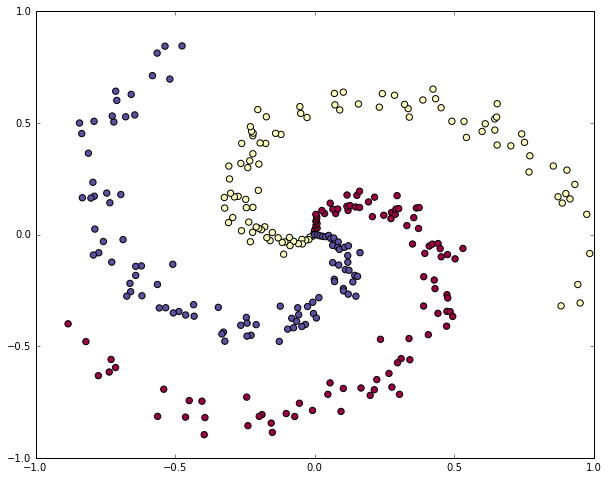

In [18]:
N = 100 # Número de pontos por class
D = 2 # dimensionalidade
K = 3 # número de classes

def create_spiral_data(N, D, K):
    x = np.zeros((N*K,D)) # matriz de dados, cada linha = uma amostra
    y = np.zeros(N*K, dtype='uint8') # labels
    
    for j in range(K):
        ix = range(N*j, N*(j+1))
        r = np.linspace(0.0,1,N) # raio
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
        x[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    
    return (x,y)

x,y = create_spiral_data(N, D, K)

plt.figure(figsize=(10,8))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(x[:,0], x[:,1], c=y, s=40, cmap=plt.cm.Spectral )

In [19]:
# Train a Softmax Linear classifier

w = 0.01 * np.random.randn(D, K)
b = np.zeros((1, K))

learning_rate = 1e-0
reg = 1e-3 # lambda

num_examples = x.shape[0]
for i in range(200):
    # calcula os scores das classes, [N x K]
    scores = np.dot(x, w) + b

    # calcula as probabilidades das clases (softmax)
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  # [N x K]

    # calcula a perda: cross-entropy media e regularização
    correct_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(correct_logprobs) / num_examples
    reg_loss = 0.5 * reg * np.sum(w * w)
    loss = data_loss + reg_loss
    if i % 10 == 0:
        print('iteration {0}: loss {1:.2f}'.format(i, loss))

    # calcula o gradiente dos scores
    dscores = probs
    dscores[range(num_examples), y] -= 1
    dscores /= num_examples

    # backpropaga o gradiente para os parametros (w,b)
    dw = np.dot(x.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)

    dw += reg * w  # regularization

    # perform a parameter update
    w += -learning_rate * dw
    b += -learning_rate * db

iteration 0: loss 1.10
iteration 10: loss 0.91
iteration 20: loss 0.84
iteration 30: loss 0.81
iteration 40: loss 0.80
iteration 50: loss 0.79
iteration 60: loss 0.78
iteration 70: loss 0.78
iteration 80: loss 0.77
iteration 90: loss 0.77
iteration 100: loss 0.77
iteration 110: loss 0.77
iteration 120: loss 0.77
iteration 130: loss 0.77
iteration 140: loss 0.77
iteration 150: loss 0.77
iteration 160: loss 0.77
iteration 170: loss 0.77
iteration 180: loss 0.77
iteration 190: loss 0.77


Training Accuracy: 0.53


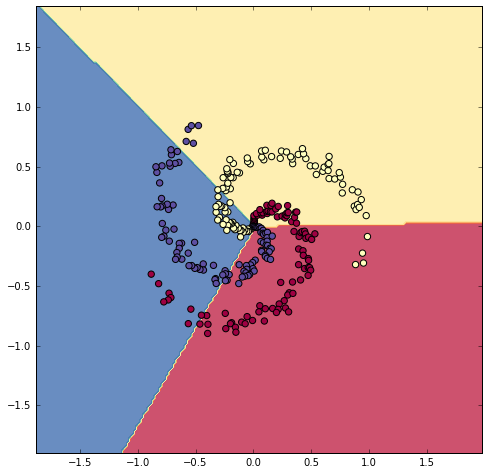

In [20]:
def accuracy(scores, y):
    predicted_class = np.argmax(scores, axis=1)
    return np.mean(predicted_class == y)

def plot_classifier(x, w, b, y, w2=None, b2=None):
    h = 0.02
    x_min, x_max = x[:,0].min() -1, x[:,0].max() + 1
    y_min, y_max = x[:,1].min() -1, x[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    if (w2 == None) and (b2 == None):
        z = np.dot(np.c_[xx.ravel(), yy.ravel()], w) + b
    else:
        z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], w) + b), w2) + b2
    z = np.argmax(z, axis=1)
    z = z.reshape(xx.shape)
    
    fig = plt.figure(figsize=(8,8))
    plt.contourf(xx, yy, z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(x[:,0], x[:,1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())    

print('Training Accuracy: {0:.2f}'.format( accuracy(np.dot(x,w)+b, y) ))
plot_classifier(x, w, b, y)

### Exemplo 3: Rede Neural

In [21]:
h = 100 # tamanho da camada oculta
w = 0.01 * np.random.randn(D, h)
b = np.zeros((1,h))
w2 = 0.01 * np.random.randn(h, K)
b2 = np.zeros((1,K))

learning_rate = 1e-0
reg = 1e-3 # regularization strengh (lambda)

num_examples = x.shape[0]
for i in range(10000):
    
    # calcula os scores das classes, [N x K]
    camada_oculta = np.maximum(0, np.dot(x,w) + b) # ReLU activation
    scores = np.dot(camada_oculta, w2) + b2
    
    # calcula as probabilidades das classes
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis = 1, keepdims=True)
    
    # calcula a perda
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(w*w) + 0.5*reg*np.sum(w2*w2)
    loss = data_loss + reg_loss
    if i % 1000 == 0:
        print('Iteration {0}: loss {1:.2f}'.format(i, loss))
    
    # calcula os gradientes nos scores
    dscores = probs
    dscores[range(num_examples), y] -= 1
    dscores /= num_examples
    
    # backpropaga os gradientes
    # primeiro em w2 e b2
    dw2 = np.dot(camada_oculta.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    
    # backprop camada oculta
    dhidden = np.dot(dscores, w2.T)
    
    # backprop ReLU
    dhidden[camada_oculta <= 0] = 0
    
    # finalmente w,b
    dw = np.dot(x.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)
    
    # add contribuição do gradiente de regularização
    dw2 += reg*w2
    dw += reg*w
    
    # atualizacao de parametros
    w += -learning_rate * dw
    b += -learning_rate * db
    w2 += -learning_rate * dw2
    b2 += -learning_rate * db2

Iteration 0: loss 1.10
Iteration 1000: loss 0.32
Iteration 2000: loss 0.26
Iteration 3000: loss 0.26
Iteration 4000: loss 0.26
Iteration 5000: loss 0.26
Iteration 6000: loss 0.26
Iteration 7000: loss 0.26
Iteration 8000: loss 0.25
Iteration 9000: loss 0.26


In [22]:
camada_oculta = np.maximum(0, np.dot(x,w) + b)
scores = np.dot(camada_oculta, w2) + b2
print('Training accuracy: {0:.2f}'.format( accuracy(scores, y) ))

Training accuracy: 0.98


/Users/arnaldo/miniconda3/envs/minicurso/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


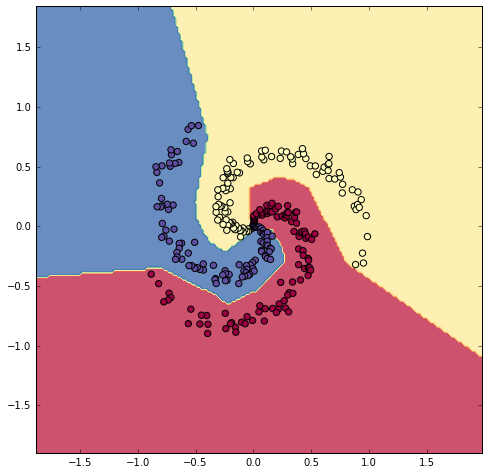

In [23]:
plot_classifier(x, w, b, y, w2, b2)

### Exemplo 4: Rede Neural Parametrizável

Por fim, vamos implementar uma rede neural parametrizável, onde se é capaz de definir o número de neurônios em cada camada, a função de transferência para cada camada, etc.

In [3]:
def sigmoid(x, Derivative=False):
    if not Derivative:
        return (1.0 / (1.0 + np.exp(-x)))
    else:
        out = sigmoid(x)
        return out * (1 - out)

def linear(x, Derivative=False):
    if not Derivative:
        return x
    else:
        return 1.0

def gaussian(x, Derivative=False):
    if not Derivative:
        return np.exp(-x**2)
    else:
        return -2*x*np.exp(-x**2)

def tanh(x, Derivative=False):
    if not Derivative:
        return np.tanh(x)
    else:
        return 1.0 - np.tanh(x)**2

def relu(x, Derivative=False):
    if not Derivative:
        return np.maximum(0, x)
    else:
        x[x <= 0] = 0
        return x

In [15]:
class NeuralNetwork(object):
    """A back-propagation network"""

    def __init__(self, layer_size, layer_functions=None):
        """Initialize the network"""

        # Layer info
        self.layer_size = len(layer_size) - 1 # input layer does not count
        self.shape = layer_size
        self.weights = []
        self.tFuncs = []

        if layer_functions is None:
            lFuncs = []
            for i in range(self.layer_size):
                if i == self.layer_size - 1:
                    lFuncs.append(linear)
                else:
                    lFuncs.append(sigmoid)
        else:
            if len(layer_size) !=  len(layer_functions):
                raise ValueError("Incompatible list of transfer functions.")
            elif layer_functions[0] is not None:
                raise  ValueError("Input layer cannot have a transfer function")
            else:
                lFuncs = layer_functions[1:]

        self.tFuncs = lFuncs

        # Data from last Run
        self._layerInput = []
        self._layerOutput = []
        self._previousWeightDelta = []

        # Create the weight arrays with bias
        for (l1, l2) in zip(layer_size[:-1], layer_size[1:]):
            self.weights.append(np.random.normal(scale=0.1, size=(l2, l1+1))) # +1 to add bias
            self._previousWeightDelta.append((np.zeros((l2, l1 + 1))))

    def forward(self, input):
        """Run the network based on the input data"""

        num_examples = input.shape[0]

        # Clear out the previous intermediate value lists
        self._layerInput = []
        self._layerOutput = []

        # Run it
        for index in range(self.layer_size):
            if index == 0:
                layerInput = self.weights[0].dot( np.vstack( [input.T, np.ones([1, num_examples])] ) ) # adding bias term to input and multiplying by weights
            else:
                layerInput = self.weights[index].dot( np.vstack( [self._layerOutput[-1], np.ones([1, num_examples])] ) )

            self._layerInput.append(layerInput)
            self._layerOutput.append(self.tFuncs[index](layerInput)) # applying transfer function

        return self._layerOutput[-1].T

    def trainEpoch(self, input, target, trainingRate = 0.2, momentum = 0.5):
        """Trains the network for one epoch"""

        delta = []
        num_examples = input.shape[0]

        # Run the network first
        self.forward(input)

        # Backpropagation
        for index in reversed(range(self.layer_size)):
            if index == self.layer_size - 1:
                # Compare to the target values
                output_delta = self._layerOutput[index] - target.T
                error = np.sum(output_delta**2)
                delta.append(output_delta * self.tFuncs[index](self._layerInput[index], True))
            else:
                # compare to the following layer's delta
                delta_pullback = self.weights[index + 1].T.dot(delta[-1])
                delta.append(delta_pullback[:-1, :] * self.tFuncs[index](self._layerInput[index], True))

        # Compute weight deltas
        for index in range(self.layer_size):
            delta_index = self.layer_size - 1 - index

            if index == 0:
                layerOutput = np.vstack([input.T, np.ones([1, num_examples])])
            else:
                layerOutput = np.vstack([self._layerOutput[index - 1], np.ones([1, self._layerOutput[index - 1].shape[1]])])

            curWeightDelta = np.sum(layerOutput[None,:,:].transpose(2,0,1) * delta[delta_index][None,:,:].transpose(2,1,0), axis = 0)

            weightDelta = trainingRate * curWeightDelta + momentum * self._previousWeightDelta[index]

            self.weights[index] -= weightDelta
            self._previousWeightDelta[index] = weightDelta

        return error

In [22]:
input = np.array([[0, 0], [1, 1], [1, 0], [0, 1]])
target = np.array([[1.00], [1.00], [0.00], [0.00]])
layer_funcs = [None, sigmoid, linear]

nn = NeuralNetwork((2, 4, 1), layer_functions=layer_funcs)

lnMax = 100000
lnErr = 1e-5
for i in range(lnMax+1):
    err = nn.trainEpoch(input, target, momentum=0.7)
    if i % 2500 == 0:
        print("Iteration {0}\tError: {1:0.6f}".format(i, err))
    if err <= lnErr:
        print("Minimum error reached at iteration {0}".format(i))
        break

# Display output
output = nn.forward(input)
for i in range(input.shape[0]):
    print("Input: {0} Output: {1}".format(input[i], output[i]))
print(nn.weights)

Iteration 0	Error: 2.730104
Minimum error reached at iteration 1372
Input: [0 0] Output: [ 0.99922536]
Input: [1 1] Output: [ 0.99800902]
Input: [1 0] Output: [ 0.00132311]
Input: [0 1] Output: [ 0.0014084]
[array([[-3.47268789, -3.68204948,  0.60064044],
       [-1.42668093, -0.39887377,  0.66953901],
       [ 0.050057  , -1.85391709,  0.28576935],
       [ 1.29845151,  0.45795851, -0.65964918]]), array([[ 3.70319901, -1.97562301, -2.14752124,  1.73952456,  0.54765282]])]


## <a href='http://goo.gl/forms/6zO1zkIDVwLFQsCN2'>Link para o Questionário</a>